### Continuous Manufacturing

- Multi-output regression (15 outputs at 2 stages each)

In many machine learning applications, many features are used to either predict a singular class, or else make a single continuous value prediction. In other situations, however it is necessary to predict multiple labels from a single set of features. This case study focuses on one such example of multi-output regression.

In industry, there are three main types of processes: batch, semi-batch, and continuous. As the names suggest, the batch and semi-batch processes are performed as a batch or group. These processes are typically used for expensive products or specialty orders (e.g. batches of a type of cookie, algal pools, semiconductor wafers). Continuous processes are typically used for products in such high demand that overproduction is not a concern (gasoline, soda ash). 

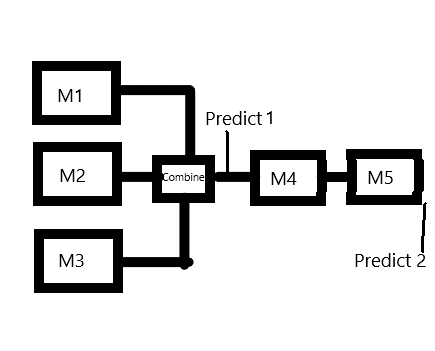

Data was collected from a continuous production line near Detroit, Michigan which followed the below block flow diagram. Three separate machines work in parallel with their outputs entering into a combination step. This is considered stage 1. From stage 1, the output stream is fed into machines 4 and 5 in series before outputting the final product stream. The goal is to use the 42 known machine conditions for the first stage to predict 15 output stream properties at the combination step. The next goal is to use the known 17 machine conditions in the second stage to predict the same 15 output stream properties in the final output stream.
 
With multi-output models, a few strategies can be chosen. Some model classes in sci-kit learn and other machine learning packages support multiple outputs and do not require any additional model engineering. If this approach is not chosen, then additional measures must be taken. One method is to create a model with a single multidimensional vector, where each dimension represents a different output label. Another approach, and perhaps the most straight forward, is to create a separate model for each output. The combined predictions of all of these models constitute the true output. With this multi-model method, the outputs of the previous models can be added to the feature space of the subsequent models to capture any interdependence the analyst may be aware of from domain knowledge. This last method can also instead be used to reveal dependence between labels if dependence was unknown beforehand.

**Activity**: Create a multi-output regression model to predict stage 1 and stage 2 output properties from the given features. Keep in mind that stage 2 features and data should not be used in the prediction of the first stage but the first stage data may be used to predict the second stage if desired.

### Install Packages (restart kernel to use)

In [1]:
try:
    from prettytable import PrettyTable as pptt
except:
    !pip install prettytable

### Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler as RUS
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import xgboost as xgb
import zipfile

### Import and View Data

In [3]:
# unzip data file
zf = zipfile.ZipFile('continuous_factory_process.zip')
data = pd.read_csv(zf.open('continuous_factory_process.csv'))
print(data.shape)
data.head()

(14088, 116)


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


### Part 1: Predict Output 1 Conditions

- Separate Features and Labels for Stage 1 from Stage 2
- Visualize Correlations and Spread

C:\Users\johnh\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


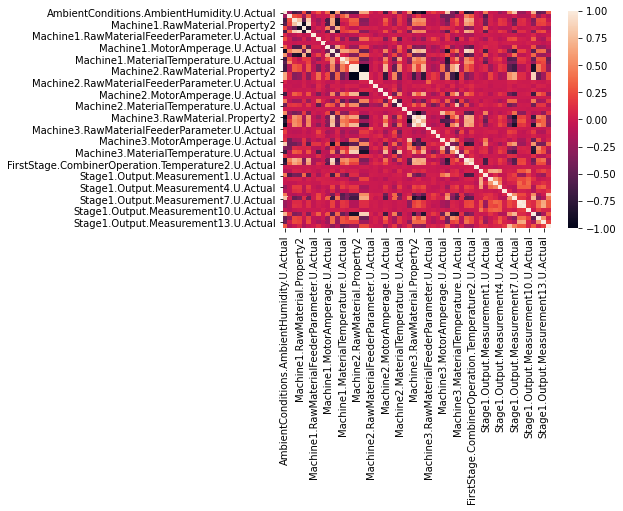

In [4]:
# sns.heatmap(data.corr())
list(data.columns)
#For output1: Ambient, time?, Mach123, firststage predict stage1.setpoint
output1 = []
desired1i = ['ambient', 'time', 'machine1','machine2','machine3','firststage']
input1 = []
for name in data.columns:
    
    for want in desired1i:
        if want in name.lower():
            input1.append(name)
    if 'stage1' in name.lower() and 'actual' in name.lower():
        output1.append(name)
first = input1+output1
dataf = data[first]
sns.heatmap(dataf.corr())
# plt.figure(figsize=(25,25))
plt.savefig('Corrmap.png')
rep = ProfileReport(dataf,correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True},
    })
# rep.to_file(output_file='Flow1_report.html')

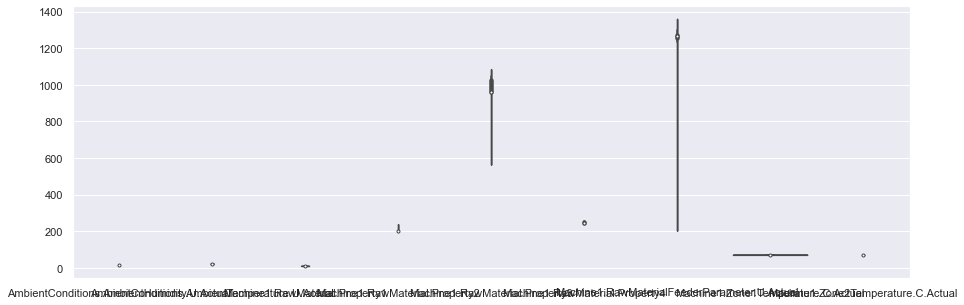

<AxesSubplot:>

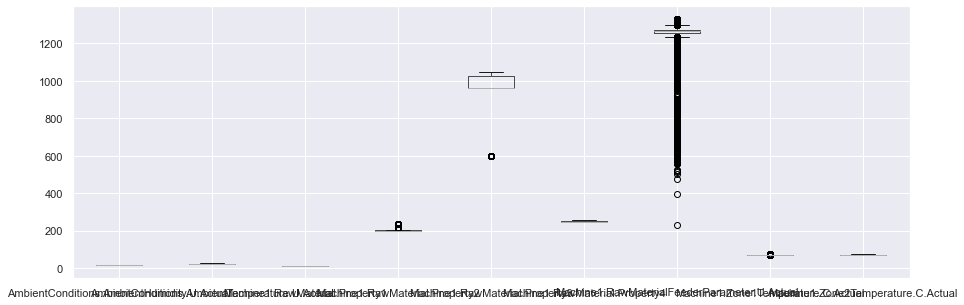

In [5]:
# sns.violinplot(dataf[input1])
inp = dataf[input1]
sns.set(rc={'figure.figsize':(15,5)})
sns.violinplot(data=dataf[input1[:int(len(input1)//4)]])

plt.show()
dataf[input1[:int(len(input1)//4)]].boxplot()

In [6]:
type(dataf[input1[-1]])

pandas.core.series.Series

### Data engineering: Can't remove outliers

Typically, removing outliers helps the model train on "True" data. Caution must always be taken when excluding data from your dataset; if you cannot justify the outliers as mistakes, then they are part of your system. For example the machine very well may get twice as hot as the typical operating temperature. That data is important and should not be removed.

Below, we see another problem. If we drop outliers across the dataset, almost no data is left over. When working with many different measuring devices for presumably independent properties, the devices will often give bad or outlier readings without respect to eachother. The outliers and null readings are therefore spread across all of the data and a general dataframe.dropna() etc. will remove the majority of the set.

<AxesSubplot:>

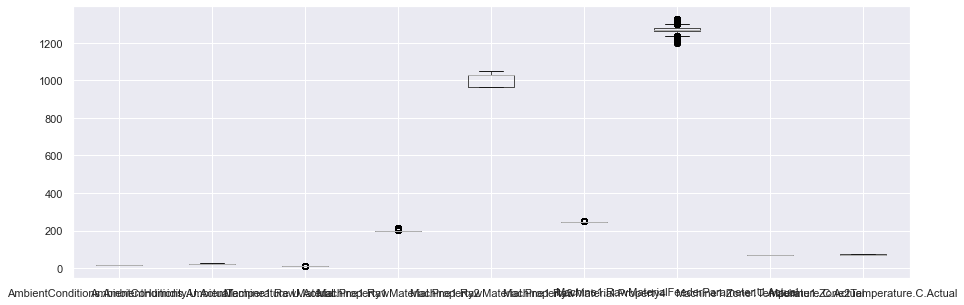

In [7]:
Q1 = dataf[input1].quantile(0.15)
Q3 = dataf[input1].quantile(0.85)
IQR = Q3 - Q1

df = dataf[~((dataf[input1] < (Q1 - 1.5 * IQR)) |(dataf[input1] > (Q3 + 1.5 * IQR))).any(axis=1)]
df[input1[:int(len(input1)//4)]].boxplot()

In [8]:
df1 = df[df[output1] !=0]
print(df1[output1].count(0))
df.shape, df1.shape, dataf.shape
dataf[output1].count(0)

Stage1.Output.Measurement0.U.Actual     7778
Stage1.Output.Measurement1.U.Actual     5365
Stage1.Output.Measurement2.U.Actual     7773
Stage1.Output.Measurement3.U.Actual     7728
Stage1.Output.Measurement4.U.Actual     7739
Stage1.Output.Measurement5.U.Actual      362
Stage1.Output.Measurement6.U.Actual     4949
Stage1.Output.Measurement7.U.Actual     2871
Stage1.Output.Measurement8.U.Actual     7413
Stage1.Output.Measurement9.U.Actual     7455
Stage1.Output.Measurement10.U.Actual    7660
Stage1.Output.Measurement11.U.Actual    1733
Stage1.Output.Measurement12.U.Actual    6050
Stage1.Output.Measurement13.U.Actual    7630
Stage1.Output.Measurement14.U.Actual    4734
dtype: int64


Stage1.Output.Measurement0.U.Actual     14088
Stage1.Output.Measurement1.U.Actual     14088
Stage1.Output.Measurement2.U.Actual     14088
Stage1.Output.Measurement3.U.Actual     14088
Stage1.Output.Measurement4.U.Actual     14088
Stage1.Output.Measurement5.U.Actual     14088
Stage1.Output.Measurement6.U.Actual     14088
Stage1.Output.Measurement7.U.Actual     14088
Stage1.Output.Measurement8.U.Actual     14088
Stage1.Output.Measurement9.U.Actual     14088
Stage1.Output.Measurement10.U.Actual    14088
Stage1.Output.Measurement11.U.Actual    14088
Stage1.Output.Measurement12.U.Actual    14088
Stage1.Output.Measurement13.U.Actual    14088
Stage1.Output.Measurement14.U.Actual    14088
dtype: int64

At this point, I can either try to use the best 42 inputs to predict the 15 outputs all at once, or I can find the best inputs for each output, then evaluate from there. At first I planned to do a k-nearest neighbors approach for the first method, and compare that to the second method. But the zeros are scattered throughout the data, so I can only try the second method.
### Create training class
This class will take an initialized model, find the best features for each label, train using those features, and score itself. Training takes longer as there are n models for n outputs to train rather than a single one.<br>
Another step that could be taken in the future is to pass the predicted values for one label as a feature for the next. This would need to be done with domain knowledge as I cannot tell which one may influence the other and make practical sense to include. In this case, practical sense means that you are physically able to predict the one before the other. Some datasets disguise these forwards or backwards dependencies, which is why I avoid trying this technique with these data.

In [9]:
class group_training():
    def __init__(self, model, input_col, output_col, xtrain, ytrain, \
                 xtest, ytest, options={'plot':False}):
        self.model = model
        self.options = options
        self.input_col = input_col
        self.output_col = output_col
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xtest = xtest
        self.ytest = ytest
        self.data = xtrain.join(ytrain)
        self.models = []

    class trained():
        def __init__(self, model, inputs, output, score, perc):
            self.model = model
            self.inputs = inputs
            self.output = output
            self.score = score
            self.perc = perc

    def training(self):
        if "kbest" in self.options.keys():
            kbest = self.options['kbest']
        else:
            kbest = self.data.shape[1] // 2
        for output in tqdm(self.output_col):
            feat = SelectKBest(k='all', score_func=f_regression)
            data = self.data[self.data[output] > .01]
            dataS = data.copy()
            self.sc = mms()
            fitting = feat.fit(dataS[self.input_col], dataS[output])
            fscores = pd.DataFrame(fitting.scores_)
            fcolumns = pd.DataFrame(self.input_col)
            scores = pd.concat([fcolumns, fscores], axis=1)
            scores.columns = ['Spec', 'Score']
            scores.index = self.input_col
            scoresd = scores.sort_values(by=['Score'], ascending=False)
            bestin = scoresd.Spec[:kbest]
            m = self.model.fit(dataS[bestin], dataS[output])
            ytrue = self.ytest[self.ytest[output] > .01]

            datatest = ytrue.join(self.xtest)
            yp = m.predict(datatest[bestin])
            perc = MAPE(datatest[output], yp)
            scoree = MAE(datatest[output], yp)
            if self.options['plot']:
                plt.plot(yp, datatest[output], 'ro')
                plt.title(f'For {output}')
                plt.xlabel('Predicted')
                plt.show()
            trainee = self.trained(m, bestin, output, round(scoree, 3), round(perc, 5))
            self.models.append(trainee)

    def predict(self, X: pd.DataFrame):
        result = {}
        
        for m in self.models:
            result[m.output] = m.model.predict(X[m.model.get_booster().feature_names])
        return pd.DataFrame.from_dict(result)

            
Xtrain, Xtest, ytrain, ytest = tts(dataf[input1[1:]], \
                                   dataf[output1], \
                                   test_size = .2, \
                                   random_state = 45)
a = group_training(xgb.XGBRegressor(),input1[1:],output1,Xtrain,ytrain,Xtest, ytest)
a.training()


In [10]:
x = pptt()
x.field_names = ["Output", "MAE", "MAPE"]
for m in a.models:
    if True:
        name = m.output.replace(".U.Actual",'')
        name = name.replace('Output.','')
        x.add_row([name,m.score,m.perc*100])
    else:
        print(m.output)
# a.predict(Xtrain).head()
print(x)

+----------------------+-------+---------------------+
|        Output        |  MAE  |         MAPE        |
+----------------------+-------+---------------------+
| Stage1.Measurement0  | 0.029 |        0.219        |
| Stage1.Measurement1  | 0.108 |        0.767        |
| Stage1.Measurement2  | 0.087 |        0.719        |
| Stage1.Measurement3  |  0.04 |        0.189        |
| Stage1.Measurement4  |  0.09 | 0.27299999999999996 |
| Stage1.Measurement5  | 0.068 |        2.376        |
| Stage1.Measurement6  | 0.182 |        10.549       |
| Stage1.Measurement7  | 0.024 |        0.819        |
| Stage1.Measurement8  | 0.027 |        0.131        |
| Stage1.Measurement9  |  0.09 |        0.473        |
| Stage1.Measurement10 |  0.04 |        0.515        |
| Stage1.Measurement11 |  0.04 |        0.685        |
| Stage1.Measurement12 | 0.034 |  2.2009999999999996 |
| Stage1.Measurement13 | 0.097 |        8.917        |
| Stage1.Measurement14 | 0.138 |        2.218        |
+---------

# Predict the Second Stage
 If the data were insufficient, I could  also have added in my predicted first stage as features. As discussed above, that approach can have ill-effects, but because I know for a fact that stage one is sequentially before stage two, it would be safe to use the stage one outputs as inputs for stage 2.

C:\Users\johnh\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


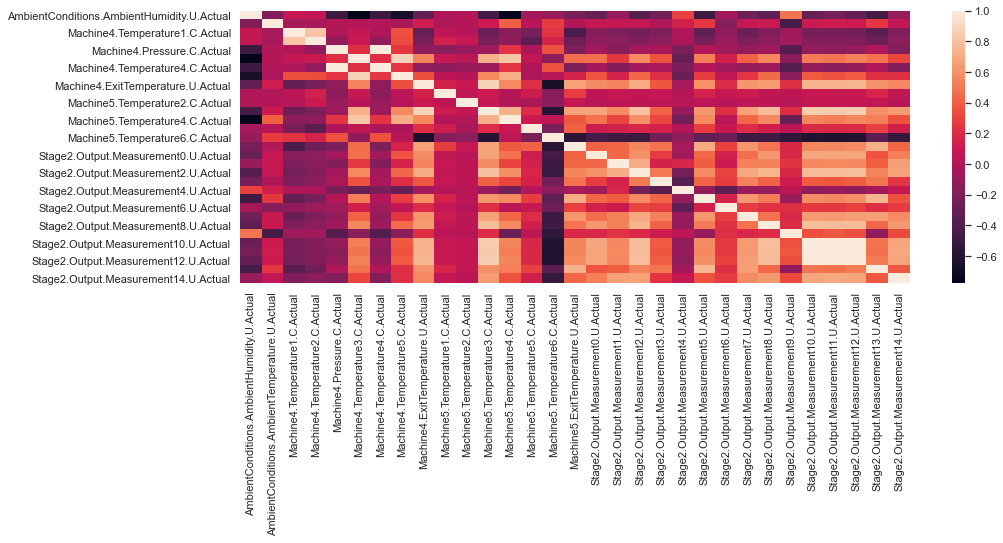

In [11]:
list(data.columns)
output2 = []
desired2i = ['ambient', 'time', 'machine4','machine5']
input2 = []
for name in data.columns:
    for want in desired2i:
        if want in name.lower():
            input2.append(name)
    if 'stage2' in name.lower() and 'actual' in name.lower():
        output2.append(name)
second = input2+output2
datasec = data[second]
sns.heatmap(datasec.corr())

rep = ProfileReport(datasec,correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": True},
    })

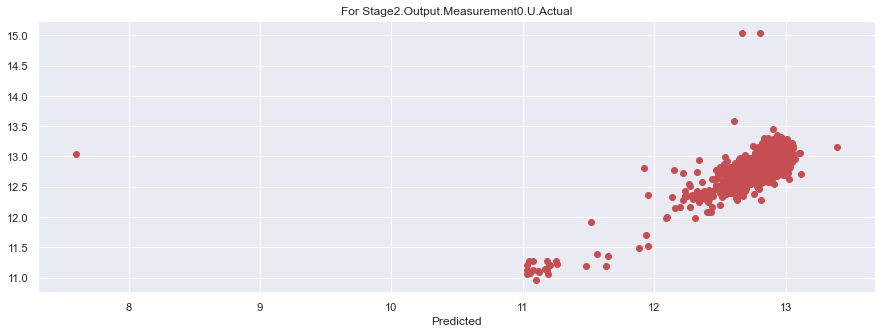

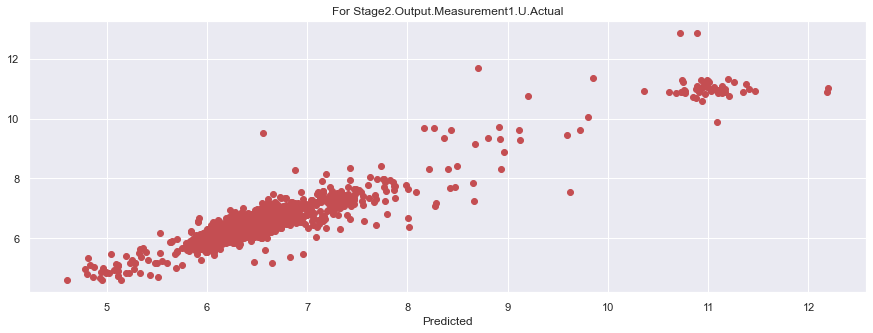

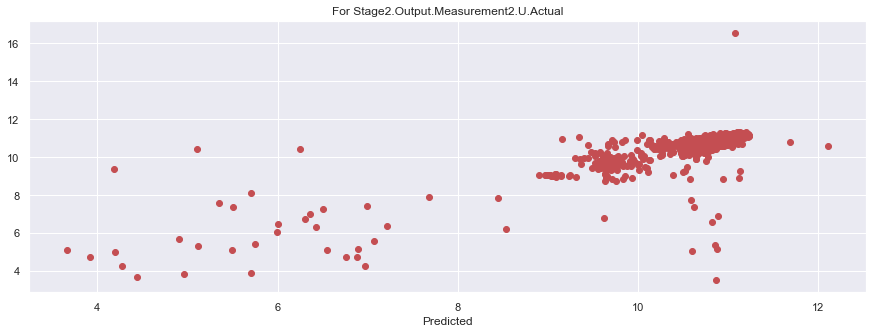

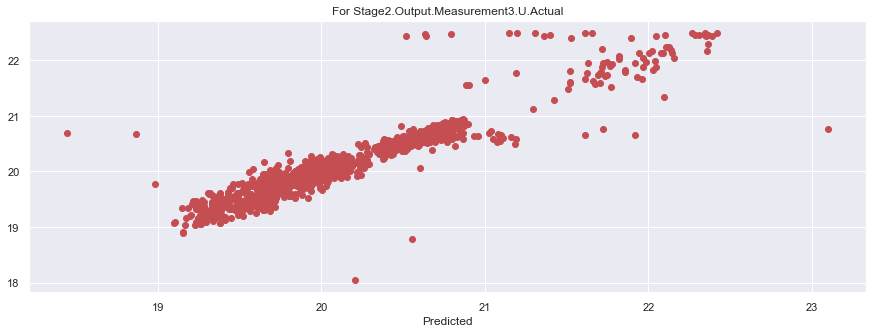

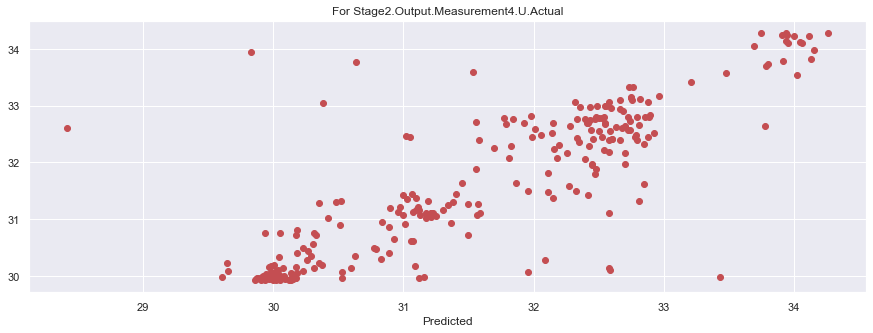

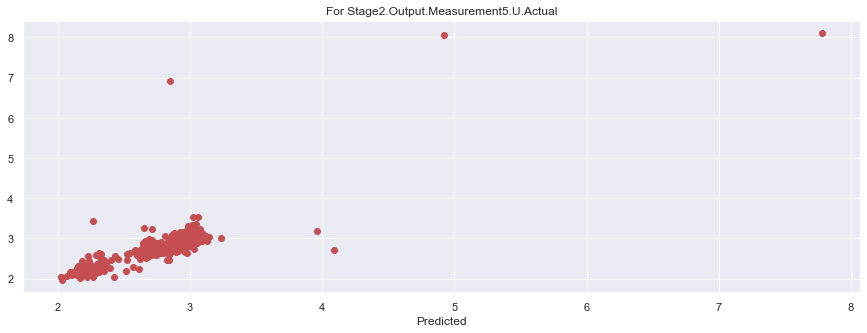

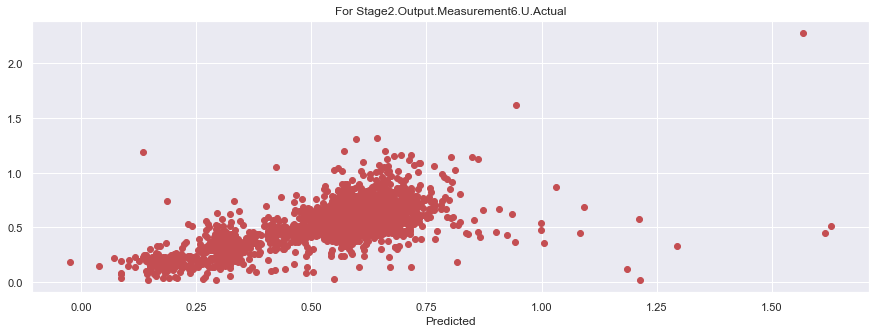

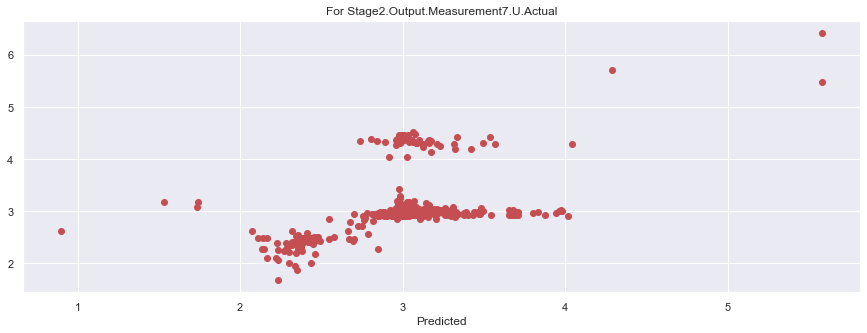

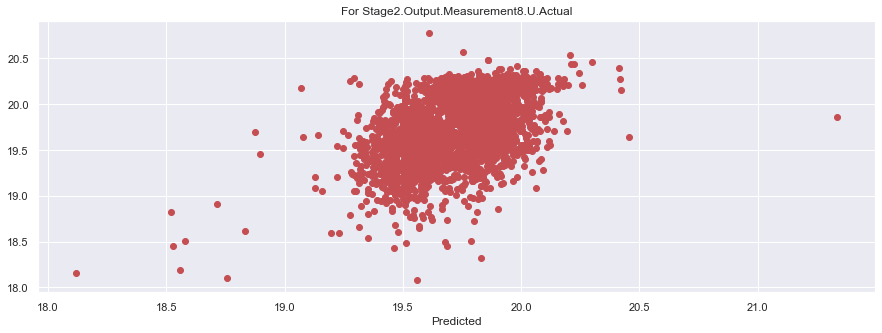

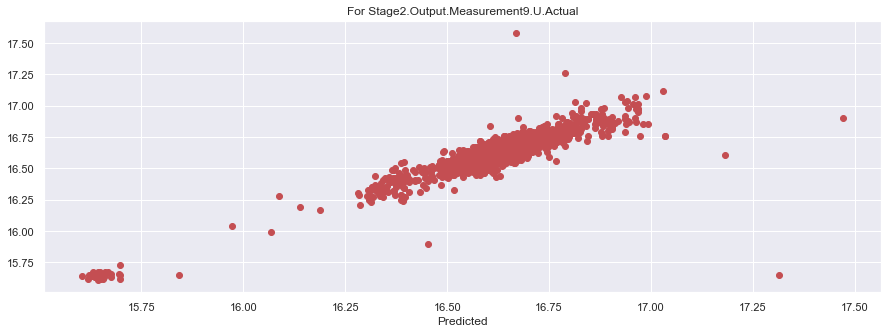

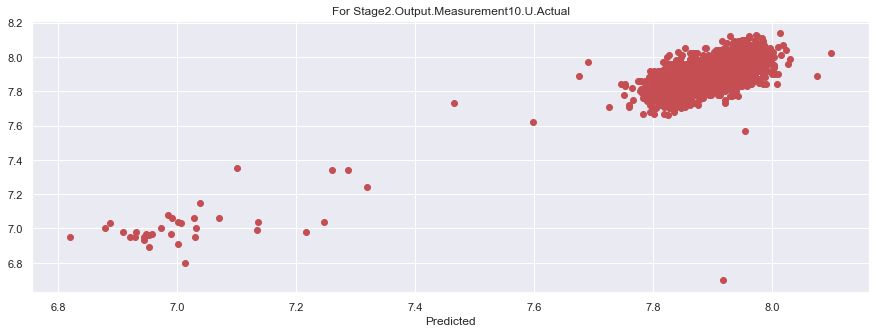

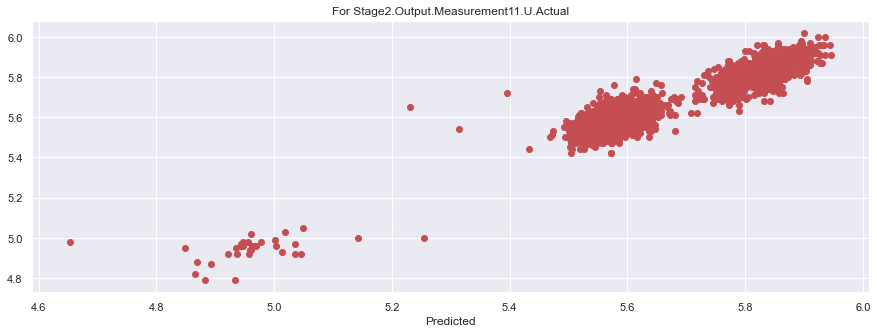

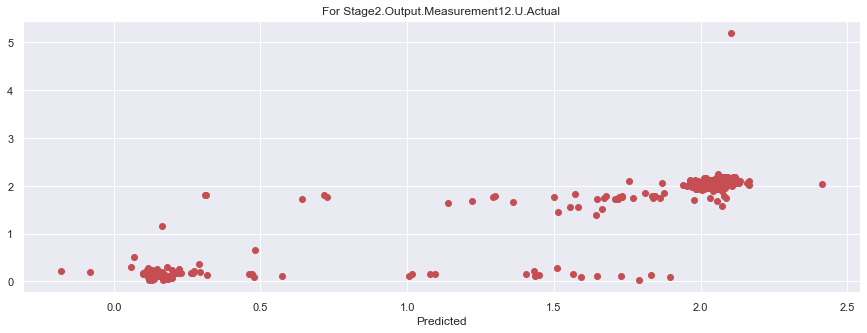

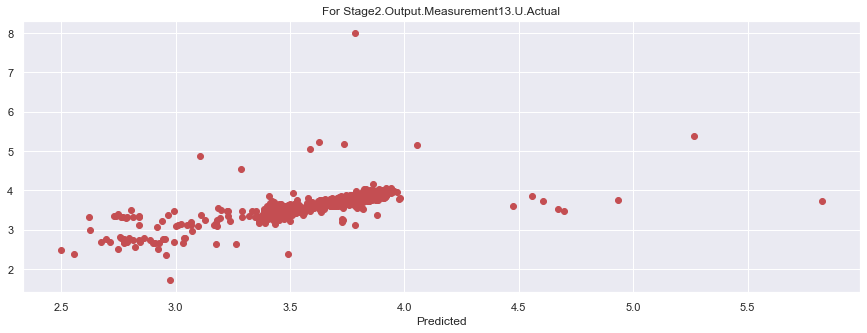

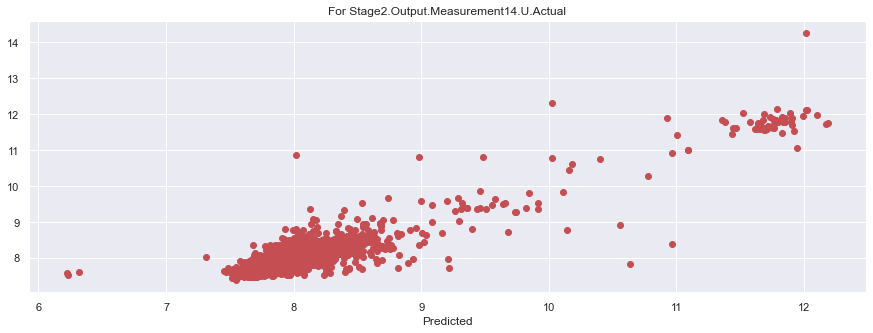

In [12]:
Xtrain, Xtest, ytrain, ytest = tts(datasec[input2[1:]], \
                                   datasec[output2], \
                                   test_size = .2, \
                                   random_state = 45)
b = group_training(xgb.XGBRegressor(),input2[1:],output2,Xtrain,ytrain,\
                   Xtest,ytest,options = {'plot':True})
b.training()

### Report Prediction Accuracy

- MAE = Mean Absolute Error
- MAPE = Mean Absolute Percent Error

In [13]:
y = pptt()
y.field_names = ["Output", "MAE", "MAPE"]
for m in b.models:
    name = m.output.replace(".U.Actual",'')
    name = name.replace('Output.','')
    y.add_row([name,m.score,m.perc*100])
print(y)
print(x)

+----------------------+-------+--------------------+
|        Output        |  MAE  |        MAPE        |
+----------------------+-------+--------------------+
| Stage2.Measurement0  | 0.094 |        0.73        |
| Stage2.Measurement1  | 0.161 |        2.41        |
| Stage2.Measurement2  | 0.151 |       1.683        |
| Stage2.Measurement3  | 0.079 |       0.387        |
| Stage2.Measurement4  | 0.399 |       1.256        |
| Stage2.Measurement5  | 0.054 | 1.8929999999999998 |
| Stage2.Measurement6  | 0.095 |       25.77        |
| Stage2.Measurement7  | 0.067 |       2.077        |
| Stage2.Measurement8  | 0.265 |       1.349        |
| Stage2.Measurement9  | 0.042 |       0.253        |
| Stage2.Measurement10 | 0.046 |       0.586        |
| Stage2.Measurement11 | 0.037 |       0.649        |
| Stage2.Measurement12 | 0.043 | 10.963000000000001 |
| Stage2.Measurement13 | 0.056 | 1.5789999999999997 |
| Stage2.Measurement14 | 0.151 |       1.849        |
+----------------------+----

In [14]:
data[output1].describe()

,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement14.U.Actual
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,1.408800e+04,14088.000000,14088.000000,1.408800e+04,14088.000000,14088.000000,14088.000000
mean,12.896919,8.050511,11.357154,21.325946,32.876441,0.124233,1.337961,1.100483,1.975402e+01,17.965964,7.681824,1.492745e+00,1.202880,2.881181,9.940519
std,0.934228,6.904337,1.052791,2.110456,3.869849,0.570191,1.135655,1.413986,4.786564e+00,4.197297,1.085486,2.542739e+00,0.663677,0.941027,7.416543
min,0.000000,-3.132803,-4.927832,0.000000,-7.688987,-0.579891,-0.745775,-0.760350,-6.588310e-20,-0.003638,-0.001439,-1.633650e-20,-0.000356,-1.225095,-6.548924
25%,12.890000,0.000000,11.200000,21.480000,33.240000,0.000000,0.000000,0.000000,2.087000e+01,18.840000,7.730000,0.000000e+00,1.390000,3.020000,0.000000
50%,12.970000,13.250000,11.310000,21.510000,33.460000,0.000000,1.640000,0.000000,2.090000e+01,18.940000,7.840000,0.000000e+00,1.500000,3.180000,15.030000
75%,13.050000,13.870000,11.520000,21.550000,34.070000,0.000000,1.820000,2.900000,2.095000e+01,19.060000,7.920000,5.410000e+00,1.570000,3.320000,15.760000
max,20.880000,19.140000,23.530000,26.240000,34.760000,4.960000,7.030000,5.190000,2.246000e+01,20.450000,13.070000,7.470000e+00,3.950000,6.910000,22.301788
